<center><h1>Saliency Estimation Experiment - DeepGazeIIE - COCO dataset</h1>
<h2>Matthias Bartolo</h2>

</center>

loading annotations into memory...
Done (t=10.06s)
creating index...
index created!


  0%|          | 0/25403 [00:00<?, ?it/s]c:\Users\User\anaconda3\envs\object_detection\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\object_detection\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\User\anaconda3\envs\object_detection\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\User\anaconda3\envs\object_detection\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
  0%|          | 2/25403 [00:10<38:34:30,  5.47s/it]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
  0%|          | 3/25403 [00:20<54:02:43,  7.66s/it]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
  0%|          | 4/25403 [00:31<61:53:39,  8.77s/it]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
  0%|          | 4/25403 [00:41<73:08:11, 10.37s/it]


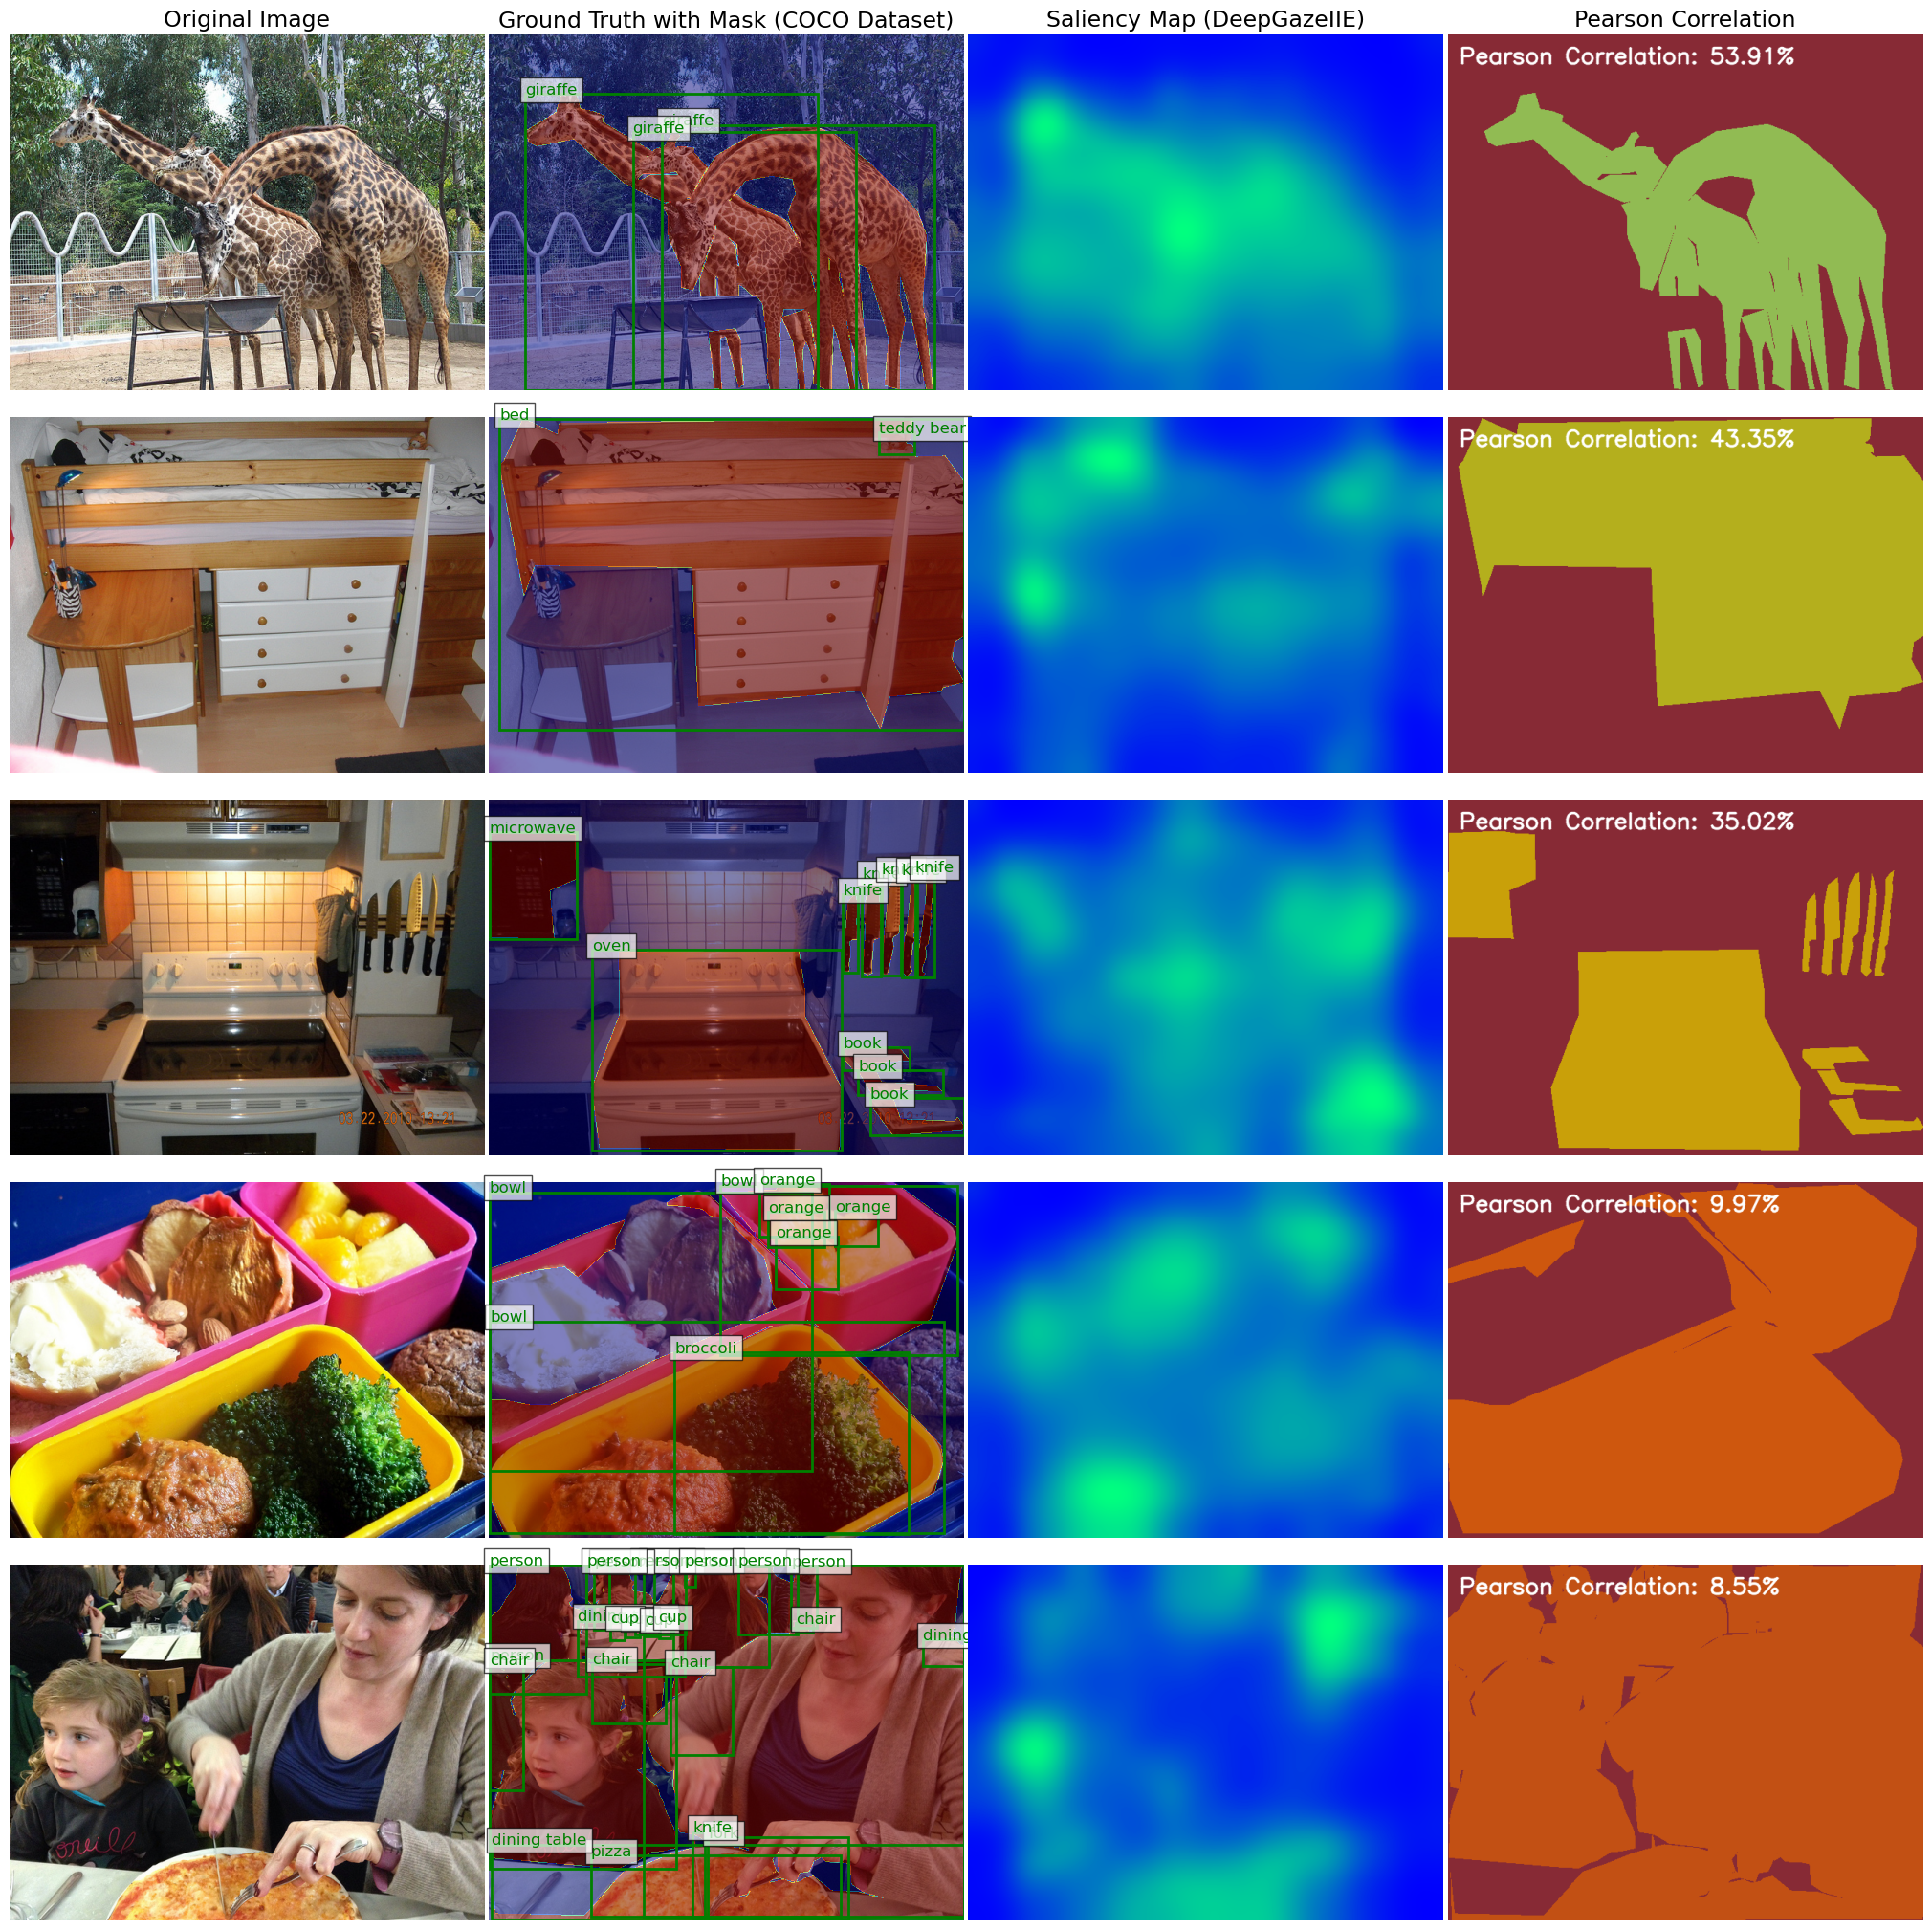

In [3]:
import os
from PIL import Image
import torch
import numpy as np
from pycocotools.coco import COCO
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib.patches as patches

import SaRa.saraRC1 as sara
GENERATORS = ['itti', 'deepgaze']
generator = 'deepgaze'

coco_version = "2017"
data_type = "train"

# Path to the COCO annotation file
coco_annotation_file = f"COCODataset/annotations/instances_{data_type}{coco_version}.json"

# Folder containing COCO images
image_folder = f"COCODataset/{data_type}{coco_version}"

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load COCO dataset and annotations
coco = COCO(coco_annotation_file)

# Function to extract object masks, bounding boxes, and category labels from the COCO dataset
def get_coco_masks_and_labels(image_id, coco):
    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)
    
    mask = None
    bboxes = []
    categories = []
    
    for ann in annotations:
        if 'segmentation' in ann:
            segmentation = coco.annToMask(ann)
            if mask is None:
                mask = segmentation
            else:
                mask = np.maximum(mask, segmentation)
        
        if 'bbox' in ann:
            bboxes.append(ann['bbox'])  # Bounding box [x, y, width, height]
            category_id = ann['category_id']
            category_name = coco.loadCats(category_id)[0]['name']
            categories.append(category_name)
    
    return mask, bboxes, categories

# Function to process a single image and return results for grid display
def process_image(image_file):
    # Load image
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path)

    # Perform saliency inference using SaRa
    image = np.array(image)
    sara_image = image.copy()
    sara.reset()

    saliency_map = sara.return_saliency(sara_image, generator=generator)

    # Convert image filename to image_id (assuming COCO image naming convention)
    image_id = int(image_file.split('.')[0])

    # Get the object mask, bounding boxes, and category labels for the image from COCO annotations
    object_mask, bboxes, categories = get_coco_masks_and_labels(image_id, coco)

    if object_mask is None:
        return None

    # Resize mask to match the depth map dimensions
    depth_map_resized = cv2.resize(np.array(saliency_map), (object_mask.shape[1], object_mask.shape[0]))

    # Flatten the object mask and depth map for Pearson correlation
    flattened_mask = object_mask.flatten()
    flattened_depth = depth_map_resized.flatten()

    # Pearson correlation between object mask and depth values
    correlation, _ = pearsonr(flattened_mask, flattened_depth)

    return image, object_mask, depth_map_resized, bboxes, categories, correlation

# Get list of image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Shuffle the image files and select 5 iamges with similar sizes
# np.random.shuffle(image_files)

# Pick the first image and then select images with similar sizes
image_file = image_files[0]
image_path = os.path.join(image_folder, image_file)
image = Image.open(image_path)
image_size = image.size

# Filter 5 images with similar sizes
image_files = [f for f in image_files if Image.open(os.path.join(image_folder, f)).size == image_size]

# Only process 5 images for demonstration purposes (Sample from the iamges, and choose images with similar sizes)
selected_images = []
for image_file in tqdm(image_files):
    result = process_image(image_file)
    if result is not None:
        selected_images.append(result)
    if len(selected_images) == 5:
        break

# Sort images based on Pearson correlation
selected_images = sorted(selected_images, key=lambda x: x[-1], reverse=True)

# Create a 5x4 grid of images
fig, axes = plt.subplots(5, 4, figsize=(20, 25))

# Define column titles
column_titles = [
    "Original Image",
    "Ground Truth with Mask (COCO Dataset)",
    "Saliency Map (DeepGazeIIE)",
    "Pearson Correlation"
]

# Set column titles
for col, title in enumerate(column_titles):
    axes[0, col].set_title(title, fontsize=17)

for i, (image, object_mask, depth_map, bboxes, categories, correlation) in enumerate(selected_images):
    row = i
    # Original Image
    axes[row, 0].imshow(image)
    axes[row, 0].axis("off")

    # Ground Truth with Mask and Labels
    ax = axes[row, 1]
    ax.imshow(image)
    ax.imshow(object_mask, cmap="jet", alpha=0.5)  # Overlay mask with color
    for bbox in bboxes:
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)
    for j, bbox in enumerate(bboxes):
        x, y, width, height = bbox
        category = categories[j]
        ax.text(x, y, category, color='green', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    ax.axis("off")

    # Depth Map
    axes[row, 2].imshow(depth_map, cmap="winter")
    axes[row, 2].axis("off")

    # Pearson Correlation Heatmap
    correlation_map = np.zeros_like(object_mask, dtype=float)
    correlation_map[object_mask == 1] = correlation
    # Add to the correlation map white text with the correlation value
    percentage_text = f"Pearson Correlation: {correlation * 100:.2f}%"
    # Change the correlation map to RGB by truning it into a green ehatmap
    correlation_map_rgb = cv2.applyColorMap((correlation_map * 255).astype(np.uint8), cv2.COLORMAP_PARULA)
    cv2.putText(correlation_map_rgb, percentage_text, (15, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    axes[row, 3].imshow(correlation_map_rgb, cmap="Greens", vmin=-1, vmax=1)
    axes[row, 3].axis("off")

# Adjust layout to remove extra space and fit titles
plt.subplots_adjust(left=0, right=1, top=0.8, bottom=0, wspace=0.01, hspace=0.0001)
plt.show()


In [4]:
import os
import time
from PIL import Image
import torch
import numpy as np
from pycocotools.coco import COCO
import cv2
from tqdm import tqdm
from scipy.stats import pearsonr
import pandas as pd

import SaRa.saraRC1 as sara
GENERATORS = ['itti', 'deepgaze']
generator = 'deepgaze'

coco_version = "2017"
data_type = "train"

# Path to the COCO annotation file
coco_annotation_file = f"COCODataset/annotations/instances_{data_type}{coco_version}.json"

# Folder containing COCO images
image_folder = f"COCODataset/{data_type}{coco_version}"

# Load COCO dataset and annotations
coco = COCO(coco_annotation_file)

# Function to extract object masks and category from the COCO dataset
def get_coco_masks_and_category(image_id, coco):
    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)

    category_to_mask = {}
    for ann in annotations:
        if 'segmentation' in ann:
            segmentation = coco.annToMask(ann)
            category_id = ann['category_id']
            if category_id in category_to_mask:
                category_to_mask[category_id] = np.maximum(category_to_mask[category_id], segmentation)
            else:
                category_to_mask[category_id] = segmentation

    return category_to_mask

# Function to process a batch of images and generate saliency maps
def generate_saliency_maps_batch(image_files, deepgaze_model=None, emlnet_models=None, DEVICE='cuda', BATCH_SIZE=32, target_size=(224, 224)):
    batch_images = []
    image_ids = []
    
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path)
        image = np.array(image)
        
        # Check if the image has 3 channels (RGB), otherwise convert it to 3 channels
        if len(image.shape) == 2:  # Grayscale image
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif image.shape[2] == 4:  # If the image has an alpha channel (RGBA), remove it
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

        # Resize image to target size
        image_resized = cv2.resize(image, target_size)
        batch_images.append(image_resized)
        
        # Convert image filename to image_id (assuming COCO image naming convention)
        image_ids.append(int(image_file.split('.')[0]))

    # Perform saliency inference in batch using SaRa
    sara.reset()
    saliency_maps = sara.return_saliency_batch(batch_images, generator=generator, deepgaze_model=deepgaze_model, emlnet_models=emlnet_models, DEVICE=DEVICE, BATCH_SIZE=BATCH_SIZE)

    # Return a list of tuples (image_id, saliency_map)
    return list(zip(image_ids, saliency_maps))


# Parameters for batch processing
BATCH_SIZE = 128
DEVICE = 'cuda'  # Set device for deepgaze model if applicable

start_time = time.time()

# Get list of image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Stage 1: Generate saliency maps for all images in batches
saliency_maps_list = []
for i in tqdm(range(0, len(image_files), BATCH_SIZE)):
    batch_files = image_files[i:i + BATCH_SIZE]
    batch_saliency_maps = generate_saliency_maps_batch(batch_files, DEVICE=DEVICE, BATCH_SIZE=BATCH_SIZE)
    saliency_maps_list.extend(batch_saliency_maps)

# Stage 2: Compute correlations based on the pre-generated saliency maps
results = []
for image_id, saliency_map in tqdm(saliency_maps_list):
    # Get the object mask and categories for the image from COCO annotations
    category_to_mask = get_coco_masks_and_category(image_id, coco)
    if not category_to_mask:
        continue

    # Resize the saliency map to match the mask size
    depth_map_resized = cv2.resize(np.array(saliency_map), (list(category_to_mask.values())[0].shape[1], list(category_to_mask.values())[0].shape[0]))

    for category_id, mask in category_to_mask.items():
        # Flatten the object mask and saliency map for easier comparison
        flattened_mask = mask.flatten()
        flattened_depth = depth_map_resized.flatten()

        # Compute Pearson correlation between object mask and saliency map
        correlation, _ = pearsonr(flattened_mask, flattened_depth)

        # Save correlation and category info
        results.append({
            'image_id': image_id,
            'category_id': category_id,
            'correlation': correlation
        })

end_time = time.time()

# Print the total processing time in minutes
print(f"Total processing time: {(end_time - start_time) / 60:.2f} minutes")

# Convert to DataFrame for easier manipulation
df_results = pd.DataFrame(results)

# Load category names from COCO dataset
categories = coco.loadCats(coco.getCatIds())
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

# Add category name to the DataFrame
df_results['category_name'] = df_results['category_id'].map(category_id_to_name)

# Group by category and calculate mean correlation for each category
category_mean_correlation = df_results.groupby('category_name')['correlation'].mean().reset_index()

# Calculate the overall mean correlation across all images and categories
overall_mean_correlation = df_results['correlation'].mean()

# Display overall and per-category mean correlations
print(f"Overall mean depth-object correlation: {overall_mean_correlation:.2f}\n")

print("Mean depth-object correlation per category:")
print(category_mean_correlation.to_string(index=False))

# Display the table of correlations for individual images and categories
table = df_results[['image_id', 'category_name', 'correlation']].to_string(index=False, header=["Image ID", "Category", "Pearson Correlation"])
print("\nTable of Correlations per Image and Category:\n")
print(table)


In [2]:
# Save the table of correlations
table_file = "correlation_table.csv"

df_results.to_csv(table_file, index=False)
print(f"\nCorrelation table saved to: {table_file}")

# Save the overall and per-category mean correlations in csv format
mean_correlation_file = "mean_correlations.csv"

mean_correlation_df = pd.DataFrame({
    'category_name': ['Overall'] + category_mean_correlation['category_name'].tolist(),
    'mean_correlation': [overall_mean_correlation] + category_mean_correlation['correlation'].tolist()
})

# Sort by mean correlation
mean_correlation_df = mean_correlation_df.sort_values(by='mean_correlation', ascending=False)

mean_correlation_df.to_csv(mean_correlation_file, index=False)
# Overall,0.16929253761284363
# Time-Taken,9946sec


Correlation table saved to: correlation_table.csv
